<a href="https://colab.research.google.com/github/skyprince999/100-Days-Of-ML/blob/master/Day_19_Plotting_functions_in_sklearn_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plotting kernel approximation functions**

A linear SVM in the original space is compared with the kernelized SVM


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA

# The digits dataset
digits = datasets.load_digits(n_class=9)

In [2]:
n_samples = len(digits.data)
print(n_samples)

1617


In [0]:
data = digits.data / 16.
data -= data.mean(axis=0)

In [0]:
# We learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])

In [0]:
# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()


In [0]:
# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])


In [7]:
# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

print("Kernel SVM time:", kernel_svm_time)
print("Linear SVM time:", linear_svm_time)

Kernel SVM time: 0.09688448905944824
Linear SVM time: 0.03110957145690918


In [0]:
sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

In [0]:
for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)


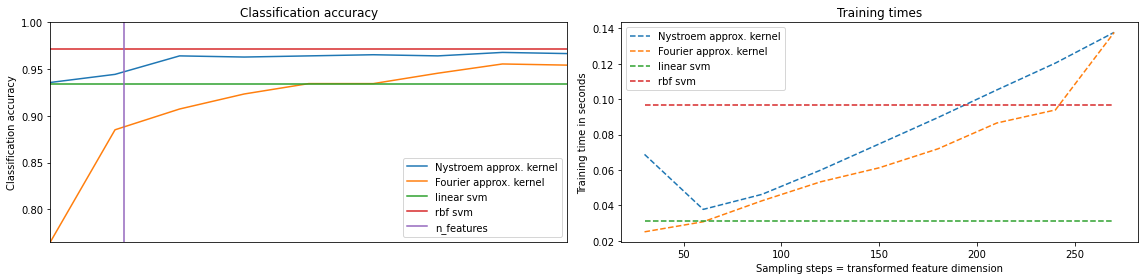

In [10]:
# plot the results:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()
plt.show()

# **Decision Surfaces of RBF Kernel SVM and Linear SVM**

The next plot will visualize the RBF & Linear kernels with approximate kernel maps. 

The plot shows decision surfaces of the classifiers projected onto the first two principal components of the data 

In [0]:
# visualize the decision surface, projected down to the first
# two principal components of the dataset
pca = PCA(n_components=8).fit(data_train)

X = pca.transform(data_train)


In [0]:
# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])


In [0]:
# title for the plots
titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100',
          'SVC (linear kernel)\n with Nystroem rbf feature map\n'
          'n_components=100']

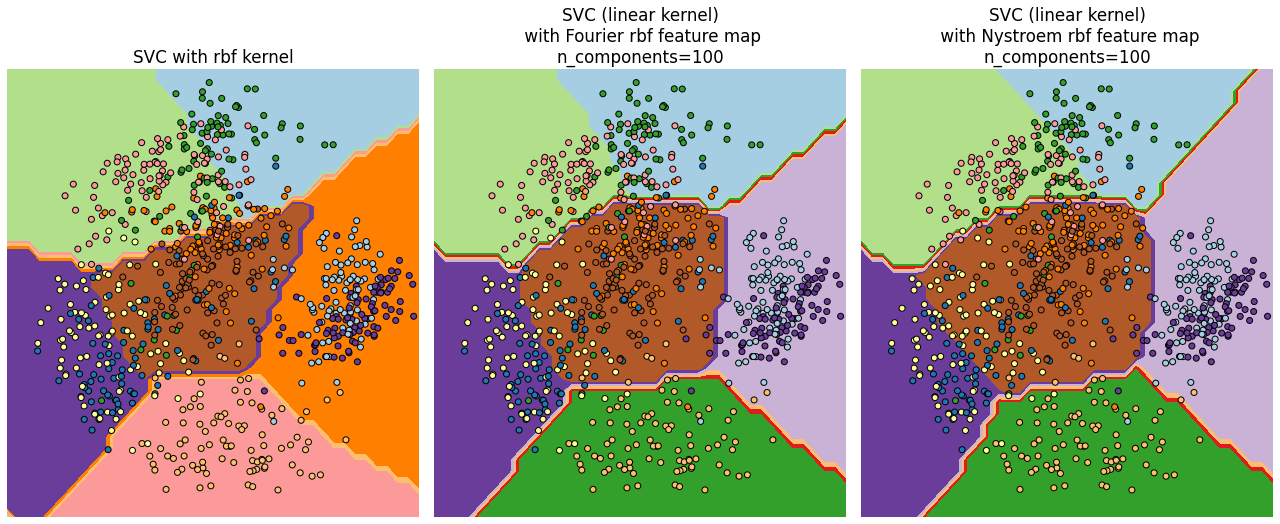

In [16]:
plt.figure(figsize=(18, 7.5))
plt.rcParams.update({'font.size': 14})
# predict and plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm,
                         fourier_approx_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=targets_train, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
plt.tight_layout()
plt.show()

# **The Johnson-Lindenstrauss bound for embedding with random projections**

``Johnson-Lindenstrauss lemma`` states that high dimensional data can be randomly projected into a lower Eucladian space while controlling the pairwise distortions


In [0]:
import sys
from time import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances

In [0]:
# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

In [0]:
# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)


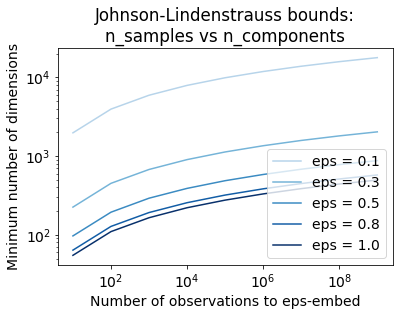

In [20]:
plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend(["eps = %0.1f" % eps for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")
plt.show()

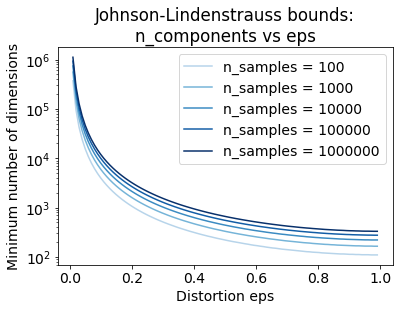

In [21]:
# range of admissible distortions
eps_range = np.linspace(0.01, 0.99, 100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))

plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples, eps=eps_range)
    plt.semilogy(eps_range, min_n_components, color=color)

plt.legend(["n_samples = %d" % n for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")
plt.show()

In [22]:
if '--use-digits-dataset' in sys.argv:
    data = load_digits().data[:500]
else:
    data = fetch_20newsgroups_vectorized().data[:500]

Embedding 500 samples with dim 130107 using various random projections
Projected 500 samples from 130107 to 300 in 0.369s
Random matrix with size: 1.300MB
Mean distances rate: 0.95 (0.19)
Projected 500 samples from 130107 to 1000 in 1.254s
Random matrix with size: 4.328MB
Mean distances rate: 0.94 (0.10)
Projected 500 samples from 130107 to 10000 in 12.570s
Random matrix with size: 43.267MB
Mean distances rate: 0.99 (0.04)


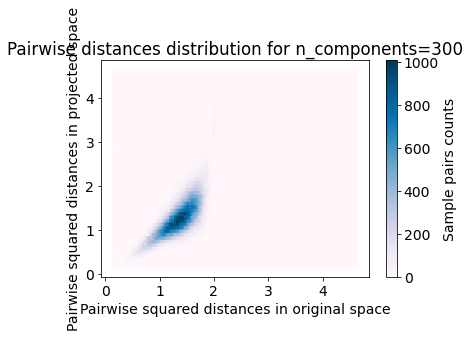

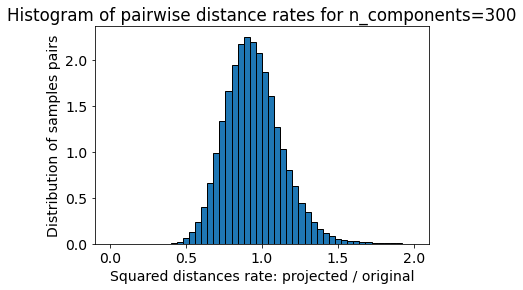

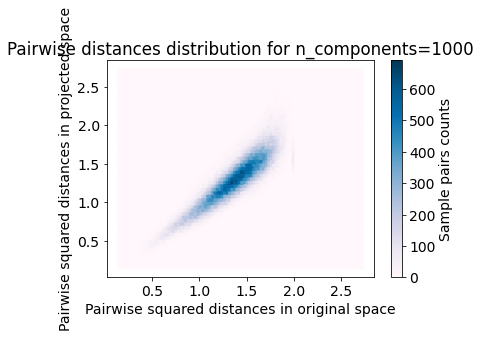

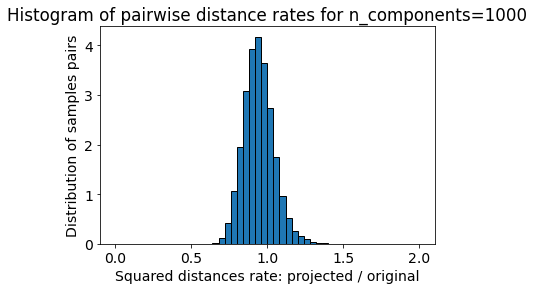

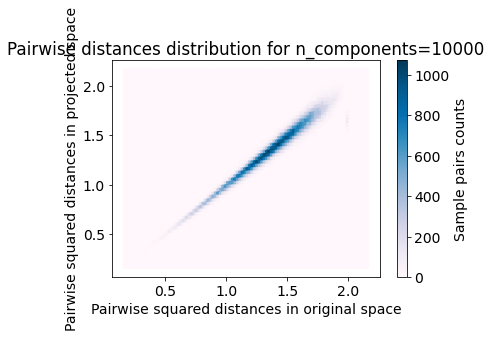

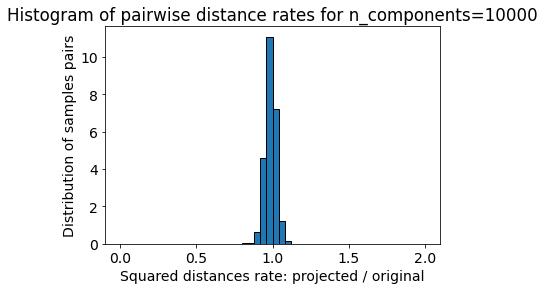

In [23]:
n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

n_components_range = np.array([300, 1000, 10000])
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu,
               extent=[min_dist, max_dist, min_dist, max_dist])
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, range=(0., 2.), edgecolor='k', **density_param)
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

    # TODO: compute the expected value of eps and add them to the previous plot
    # as vertical lines / region

plt.show()

# **Isotonic Regression** 

Automatically created module for IPython interactive environment


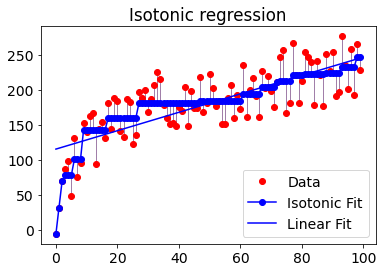

In [24]:
print(__doc__)

# Author: Nelle Varoquaux <nelle.varoquaux@gmail.com>
#         Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state

n = 100
x = np.arange(n)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(n,)) + 50. * np.log1p(np.arange(n))

# #############################################################################
# Fit IsotonicRegression and LinearRegression models

ir = IsotonicRegression()

y_ = ir.fit_transform(x, y)

lr = LinearRegression()
lr.fit(x[:, np.newaxis], y)  # x needs to be 2d for LinearRegression

# #############################################################################
# Plot result

segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(np.full(n, 0.5))

fig = plt.figure()
plt.plot(x, y, 'r.', markersize=12)
plt.plot(x, y_, 'b.-', markersize=12)
plt.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
plt.gca().add_collection(lc)
plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')
plt.title('Isotonic regression')
plt.show()

# **Compact estimator representations**

``set_config(print_changed_only=True)`` :: will print only the non-default parameters

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import set_config


lr = LogisticRegression(penalty='l1')
print('Default representation:')
print(lr)
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='auto', n_jobs=None, penalty='l1',
#                    random_state=None, solver='warn', tol=0.0001, verbose=0,
#                    warm_start=False)

set_config(print_changed_only=True)
print('\nWith changed_only option:')
print(lr)
# LogisticRegression(penalty='l1')

Default representation:
LogisticRegression(penalty='l1')

With changed_only option:
LogisticRegression(penalty='l1')


# **Compare Anamoly detection algorithms**

Automatically created module for IPython interactive environment


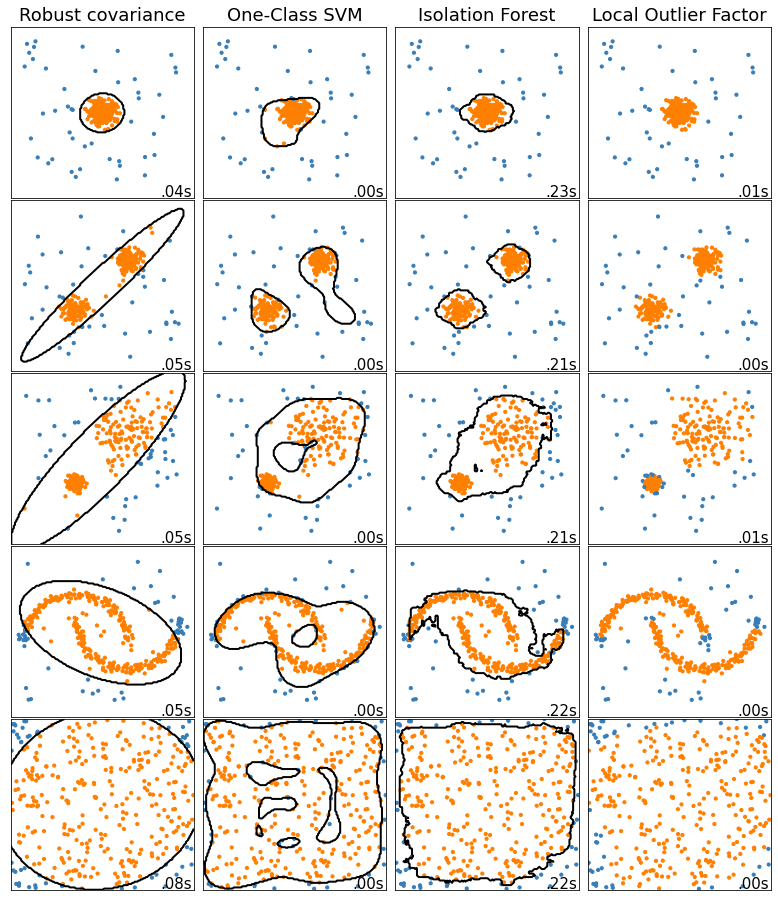

In [27]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()